# Nb-20180312-1134-RandomForest-BigGain

This is a modification of the fast.ai Machine Learning 1 random forest notebook:
- https://github.com/fastai/fastai/blob/master/courses/ml1/lesson1-rf.ipynb

Do a simple random forest to try to predict big gains in a stock ticker. Start out very simple, use only last 5 days of price info, normalized to the adjusted close of current day (i.e. divide all prices by current adjusted close).

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [4]:
import finance as fat

In [9]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [6]:
ticker = 'IBM'

In [7]:
data = fat.get_price_data(ticker)
ohlcv = data

Could not load updates for IBM from yahoo. Using cached data.
Loaded data for IBM: 1970-01-02 to 2018-03-09.


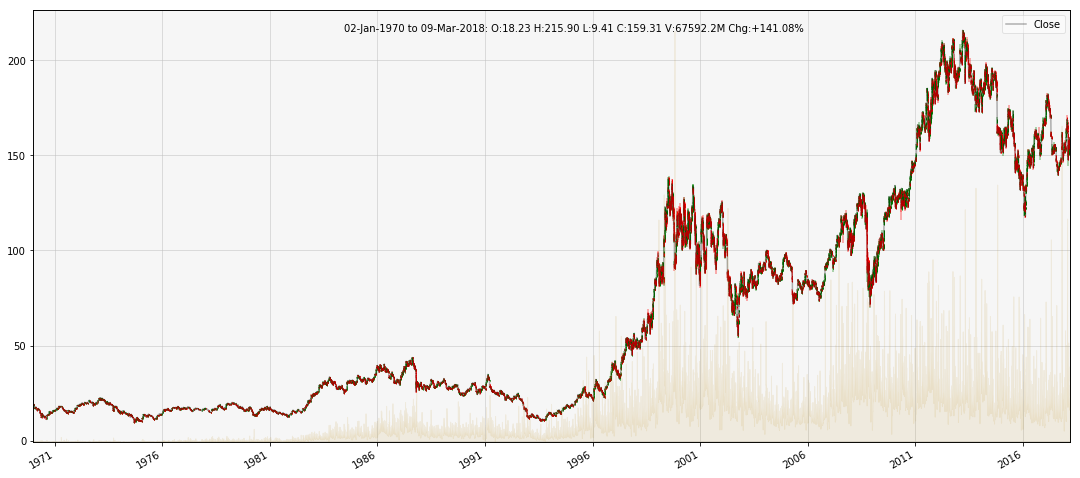

In [10]:
fat.plot_daily_ticker(ohlcv)

In [11]:
# Just use 'Adj Close'
data = pd.DataFrame(data, columns=['Adj Close'])
data.head()

,Adj Close
Date,
1970-01-02,1.689605
1970-01-05,1.705818
1970-01-06,1.706977
1970-01-07,1.708133
1970-01-08,1.711608


Get table with prices for last 5 days, and price for following day.

In [12]:
for i in range(-5, 0, 1) :
    data[f'Adj Close {i}d'] = data['Adj Close'].shift(-i)
data = data.dropna()
data.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d
Date,,,,,,
1970-01-09,1.709291,1.689605,1.705818,1.706977,1.708133,1.711608
1970-01-12,1.703502,1.705818,1.706977,1.708133,1.711608,1.709291
1970-01-13,1.733032,1.706977,1.708133,1.711608,1.709291,1.703502
1970-01-14,1.731295,1.708133,1.711608,1.709291,1.703502,1.733032
1970-01-15,1.767195,1.711608,1.709291,1.703502,1.733032,1.731295


In [13]:
scaled = data.div(data['Adj Close'], axis=0)
scaled.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d
Date,,,,,,
1970-01-09,1.0,0.988483,0.997968,0.998646,0.999323,1.001356
1970-01-12,1.0,1.001360,1.002040,1.002719,1.004758,1.003398
1970-01-13,1.0,0.984966,0.985633,0.987638,0.986301,0.982960
1970-01-14,1.0,0.986622,0.988629,0.987290,0.983947,1.001003
1970-01-15,1.0,0.968545,0.967234,0.963958,0.980668,0.979685


In [14]:
scaled['Return'] = (scaled['Adj Close'] - scaled['Adj Close -1d']) / scaled['Adj Close -1d']
scaled.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Return
Date,,,,,,,
1970-01-09,1.0,0.988483,0.997968,0.998646,0.999323,1.001356,-0.001354
1970-01-12,1.0,1.001360,1.002040,1.002719,1.004758,1.003398,-0.003387
1970-01-13,1.0,0.984966,0.985633,0.987638,0.986301,0.982960,0.017335
1970-01-14,1.0,0.986622,0.988629,0.987290,0.983947,1.001003,-0.001002
1970-01-15,1.0,0.968545,0.967234,0.963958,0.980668,0.979685,0.020736


In [15]:
scaled['Return +1d'] = scaled['Return'].shift(-1)
scaled.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Return,Return +1d
Date,,,,,,,,
1970-01-09,1.0,0.988483,0.997968,0.998646,0.999323,1.001356,-0.001354,-0.003387
1970-01-12,1.0,1.001360,1.002040,1.002719,1.004758,1.003398,-0.003387,0.017335
1970-01-13,1.0,0.984966,0.985633,0.987638,0.986301,0.982960,0.017335,-0.001002
1970-01-14,1.0,0.986622,0.988629,0.987290,0.983947,1.001003,-0.001002,0.020736
1970-01-15,1.0,0.968545,0.967234,0.963958,0.980668,0.979685,0.020736,-0.030800


In [16]:
scaled['Big Gain +1d'] = scaled['Return +1d'] > .01
scaled.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Return,Return +1d,Big Gain +1d
Date,,,,,,,,,
1970-01-09,1.0,0.988483,0.997968,0.998646,0.999323,1.001356,-0.001354,-0.003387,False
1970-01-12,1.0,1.001360,1.002040,1.002719,1.004758,1.003398,-0.003387,0.017335,True
1970-01-13,1.0,0.984966,0.985633,0.987638,0.986301,0.982960,0.017335,-0.001002,False
1970-01-14,1.0,0.986622,0.988629,0.987290,0.983947,1.001003,-0.001002,0.020736,True
1970-01-15,1.0,0.968545,0.967234,0.963958,0.980668,0.979685,0.020736,-0.030800,False


In [17]:
del scaled['Adj Close']
del scaled['Return +1d']
scaled.head()

,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Return,Big Gain +1d
Date,,,,,,,
1970-01-09,0.988483,0.997968,0.998646,0.999323,1.001356,-0.001354,False
1970-01-12,1.001360,1.002040,1.002719,1.004758,1.003398,-0.003387,True
1970-01-13,0.984966,0.985633,0.987638,0.986301,0.982960,0.017335,False
1970-01-14,0.986622,0.988629,0.987290,0.983947,1.001003,-0.001002,True
1970-01-15,0.968545,0.967234,0.963958,0.980668,0.979685,0.020736,False


### Initial processing

In [18]:
scaled = scaled.reset_index()
scaled.head()

,Date,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Return,Big Gain +1d
0,1970-01-09,0.988483,0.997968,0.998646,0.999323,1.001356,-0.001354,False
1,1970-01-12,1.001360,1.002040,1.002719,1.004758,1.003398,-0.003387,True
2,1970-01-13,0.984966,0.985633,0.987638,0.986301,0.982960,0.017335,False
3,1970-01-14,0.986622,0.988629,0.987290,0.983947,1.001003,-0.001002,True
4,1970-01-15,0.968545,0.967234,0.963958,0.980668,0.979685,0.020736,False


In [19]:
add_datepart(scaled, 'Date')
scaled.head()

,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Return,Big Gain +1d,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0.988483,0.997968,0.998646,0.999323,1.001356,-0.001354,False,1970,1,2,9,4,9,False,False,False,False,False,False,691200
1,1.001360,1.002040,1.002719,1.004758,1.003398,-0.003387,True,1970,1,3,12,0,12,False,False,False,False,False,False,950400
2,0.984966,0.985633,0.987638,0.986301,0.982960,0.017335,False,1970,1,3,13,1,13,False,False,False,False,False,False,1036800
3,0.986622,0.988629,0.987290,0.983947,1.001003,-0.001002,True,1970,1,3,14,2,14,False,False,False,False,False,False,1123200
4,0.968545,0.967234,0.963958,0.980668,0.979685,0.020736,False,1970,1,3,15,3,15,False,False,False,False,False,False,1209600


The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [20]:
train_cats(scaled)

In [21]:
scaled.isnull().sum().sort_index()/len(scaled)

Adj Close -1d       0.0
Adj Close -2d       0.0
Adj Close -3d       0.0
Adj Close -4d       0.0
Adj Close -5d       0.0
Big Gain +1d        0.0
Day                 0.0
Dayofweek           0.0
Dayofyear           0.0
Elapsed             0.0
Is_month_end        0.0
Is_month_start      0.0
Is_quarter_end      0.0
Is_quarter_start    0.0
Is_year_end         0.0
Is_year_start       0.0
Month               0.0
Return              0.0
Week                0.0
Year                0.0
dtype: float64

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [22]:
os.makedirs('tmp', exist_ok=True)
scaled.to_feather(f'tmp/{ticker}-raw')

### Pre-processing

In the future we can simply read it from this fast format.

In [23]:
df_raw = pd.read_feather(f'tmp/{ticker}-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [24]:
df, y, nas = proc_df(df_raw, 'Big Gain +1d')

In [25]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [26]:
len(df_raw)

12152

In [27]:
n_valid = int(len(df_raw)*.2)  # 20% of samples 
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((9722, 19), (9722,), (2430, 19))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [28]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Single tree

In [29]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.7746348487965439, 0.823045267489712]


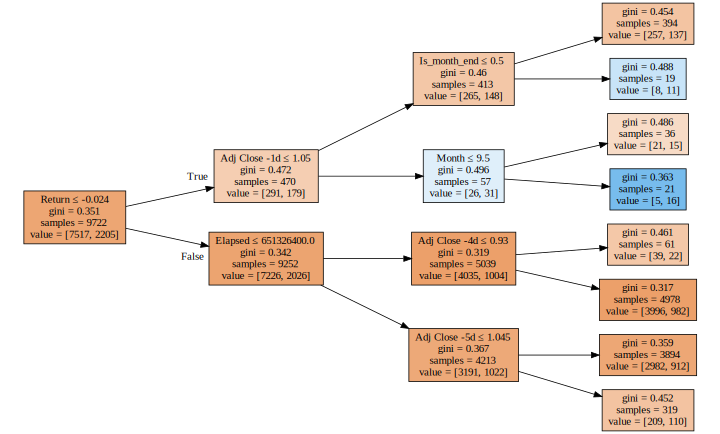

In [30]:
draw_tree(m.estimators_[0], raw_train, precision=3)

In [31]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[1995,   10],
       [ 420,    5]], dtype=int64)

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1995   10]
 [ 420    5]]


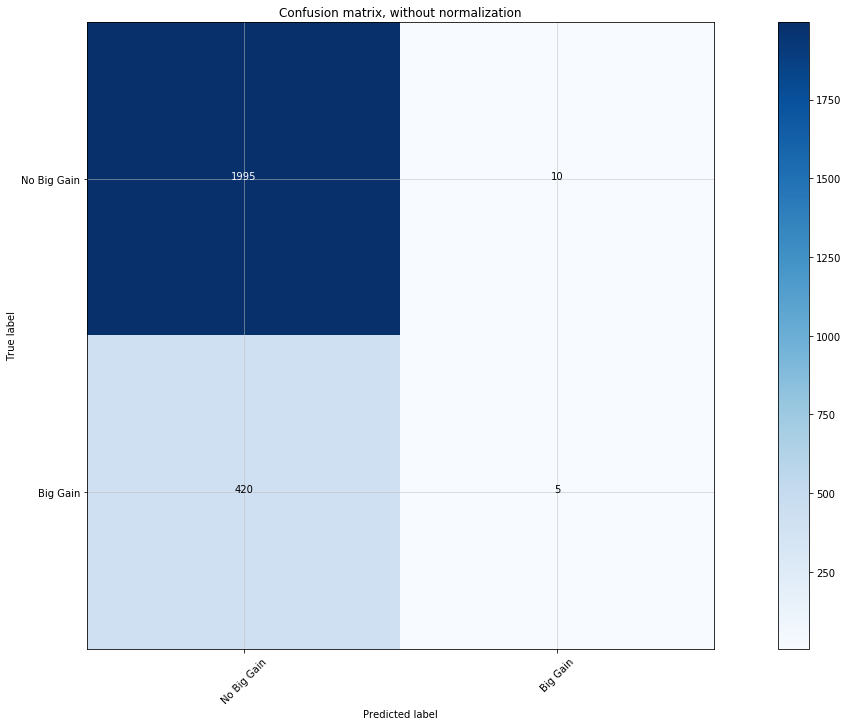

In [33]:
plot_confusion_matrix(cnf_matrix, classes=['No Big Gain', 'Big Gain'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.99501 0.00499]
 [0.98824 0.01176]]


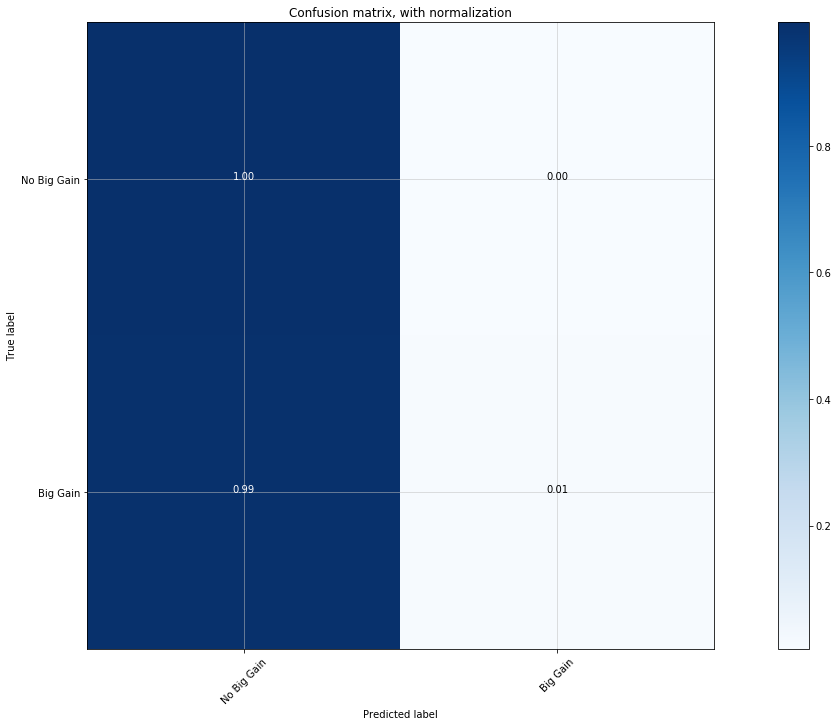

In [34]:
plot_confusion_matrix(cnf_matrix, classes=['No Big Gain', 'Big Gain'], normalize=True,
                      title='Confusion matrix, with normalization')

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [35]:
m = RandomForestClassifier(n_jobs=-1, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.973050812590002, 0.6098765432098765]


We'll grab the predictions for each individual tree, and look at one example.

In [36]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([0., 0., 1., 1., 0., 1., 1., 0., 1., 0.]), 0.5, False)

In [37]:
preds.shape

(10, 2430)

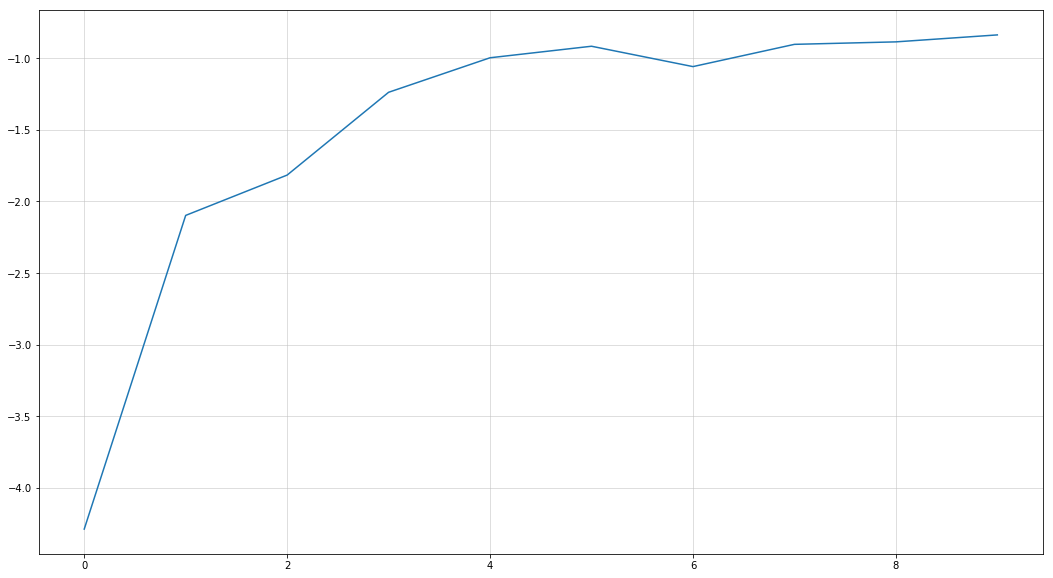

In [38]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [39]:
m = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.9922855379551533, 0.7016460905349794]


In [40]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[1629,  376],
       [ 349,   76]], dtype=int64)

Confusion matrix, without normalization
[[1629  376]
 [ 349   76]]


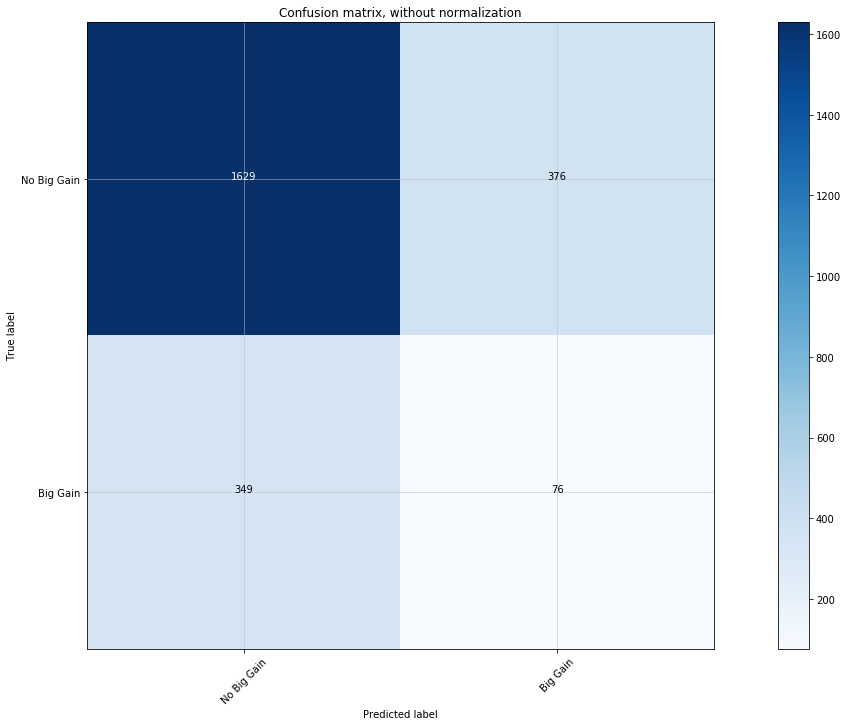

In [41]:
plot_confusion_matrix(cnf_matrix, classes=['No Big Gain', 'Big Gain'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.81247 0.18753]
 [0.82118 0.17882]]


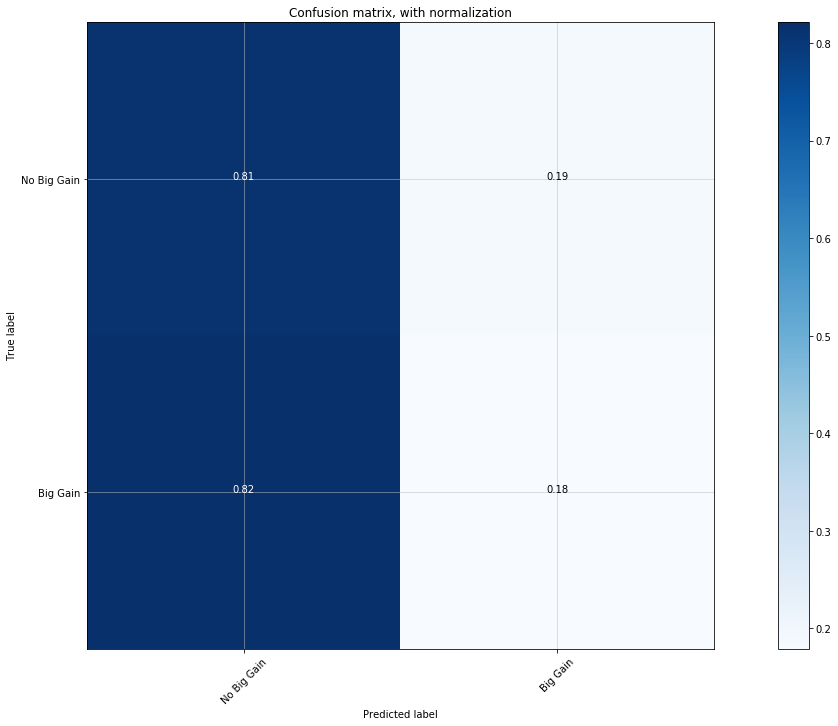

In [42]:
plot_confusion_matrix(cnf_matrix, classes=['No Big Gain', 'Big Gain'], normalize=True,
                      title='Confusion matrix, with normalization')

Not very good! Looks like it is overfitting.

In [48]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=5, max_features='sqrt', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.8343962147706233, 0.8193415637860082, 0.7680518411849414]


In [49]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[1987,   18],
       [ 421,    4]], dtype=int64)

In [50]:
metrics.accuracy_score(y_valid, y_pred)

0.8193415637860082

In [51]:
metrics.precision_score(y_valid, y_pred)

0.18181818181818182

In [52]:
metrics.recall_score(y_valid, y_pred)

0.009411764705882352

In [53]:
metrics.f1_score(y_valid, y_pred)

0.017897091722595078